In [1]:
# Import required libraries
import requests
from datetime import datetime
from typing import List, Tuple, Dict
from io import BytesIO
import numpy as np
import xml.etree.ElementTree as xmlet
import lxml.etree as xmltree
from owslib.wms import WebMapService
import os

# For data visualization
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cf
import contextily as cx

# For image processing
from PIL import Image as plimg
from PIL import ImageDraw
from IPython.display import Image, display
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# For accessing the STAC API
from pystac_client import Client

# For interactive mapping
import folium
from folium.plugins import FloatImage

In [2]:
os.getcwd()

'/home/jovyan/embell'

In [3]:
os.chdir('/home/jovyan/embell/portal2.0_maps/GEDI/')

In [4]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://dev.ghg.center/api/stac"

# The collection name is used to fetch metadata from the STAC API.
COLLECTION_NAME = "GEDI_ISS_L4B_Aboveground_Biomass_Density_Mean_201904-202303"

In [5]:
# Load collection
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(COLLECTION_NAME)
display(collection)

<CollectionClient id=GEDI_ISS_L4B_Aboveground_Biomass_Density_Mean_201904-202303>

In [6]:
GIBS_WMTS_URL = collection.links[4].href
# Use this URL to request WMTS capabilities
response = requests.get(GIBS_WMTS_URL.replace('wmts','wms')+"?SERVICE=WMS&REQUEST=GetCapabilities")

In [7]:
# Convert capability response to XML tree.
WmtsTree = xmlet.fromstring(response.content)

alllayer = []

# Parse capability XML tree to get a list and number of available layers.
for child in WmtsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                alllayer.append(f.text)

# Print the first five and last five layers.
print('Number of layers: ', len(alllayer))
for one in sorted(alllayer)[:5]:
    print(one)
print('...')
for one in sorted(alllayer)[-5:]:
    print(one)  

Number of layers:  1337
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day
AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Night
AIRS_L2_Cloud_Top_Height_Day
AIRS_L2_Cloud_Top_Height_Night
AIRS_L2_Dust_Score_Day
...
VIIRS_SNPP_SurfaceReflectance_BandsM11-M7-M5
VIIRS_SNPP_SurfaceReflectance_BandsM5-M4-M3
VIIRS_SNPP_Thermal_Anomalies_375m_All
VIIRS_SNPP_Thermal_Anomalies_375m_Day
VIIRS_SNPP_Thermal_Anomalies_375m_Night


In [8]:
GEDI_L4B_LAYERS = [l for l in alllayer if ('GEDI' in l) and ('L4B' in l)]
GEDI_L4B_LAYERS

['GEDI_ISS_L4B_Aboveground_Biomass_Density_Mean_201904-202303',
 'GEDI_ISS_L4B_Aboveground_Biomass_Density_PercentStandardError_201904-202303',
 'GEDI_ISS_L4B_Aboveground_Biomass_Density_StandardError_201904-202303',
 'GEDI_ISS_L4B_Number_of_Samples_201904-202303']

In [9]:
# Function to retrieve a legend for specified layer
def retrieve_wms_legend(tree, layer_name):
    legendImg = None

    for child in tree.iter():
        for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
             if layer.tag == '{http://www.opengis.net/wms}Layer': 
                f = layer.find("{http://www.opengis.net/wms}Name")
                if f is not None:
                    if f.text == layer_name:
                        # Style.
                        e = layer.find(("{http://www.opengis.net/wms}Style/" +
                                    "{http://www.opengis.net/wms}LegendURL/" +
                                    "{http://www.opengis.net/wms}OnlineResource"))
                        if e is not None:
                            legendURL = e.attrib["{http://www.w3.org/1999/xlink}href"]
                            legendImg = Image(url=legendURL)

    legendname = f'legend_{layer_name}.png'
    with open(legendname,'wb') as f:
        f.write(requests.get(legendURL).content)

    return legendURL,legendname

In [10]:
# Loading a shapefile for visualization
shape = gpd.read_file('../cb_2024_us_nation_5m/cb_2024_us_nation_5m.shp').to_crs(4326)

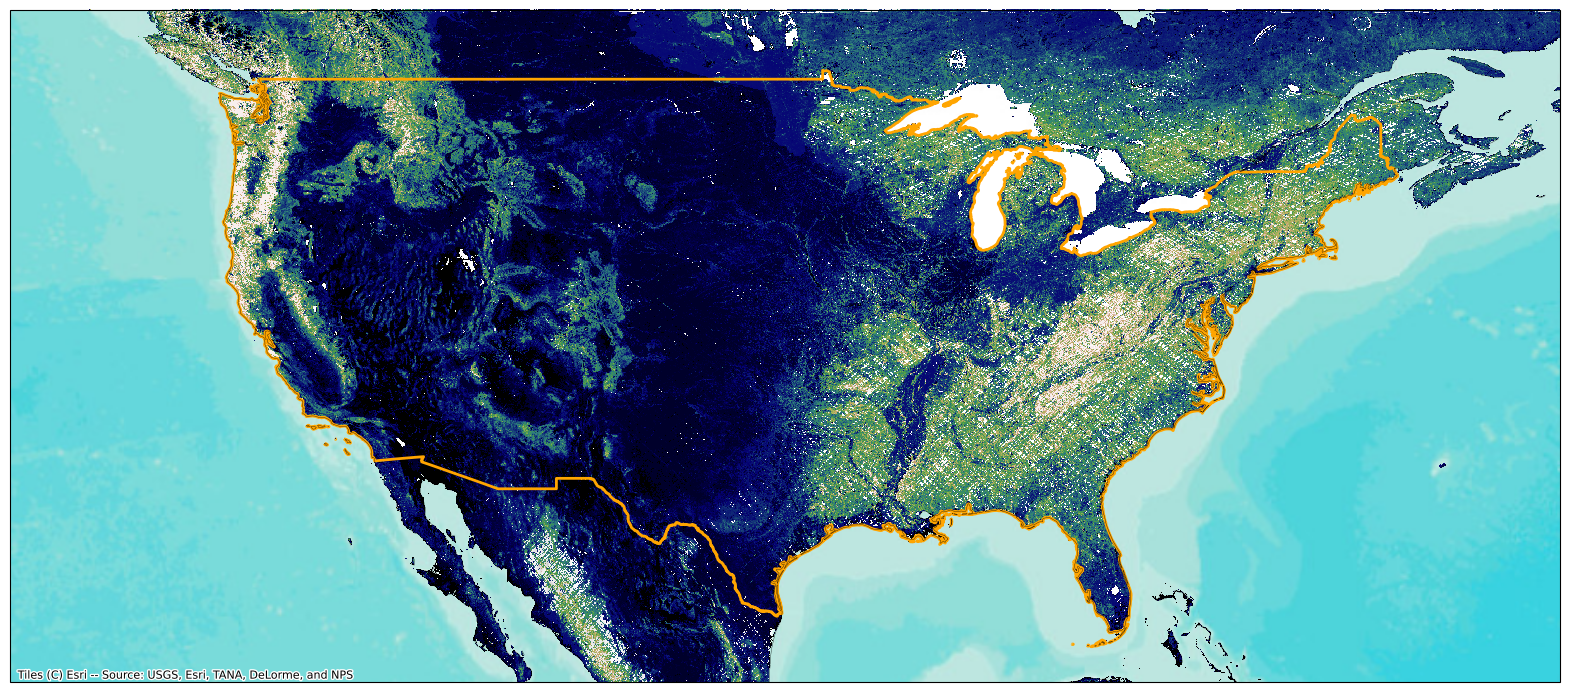

In [17]:
add_legend = False
add_shape = True

aoi_name='CONUS'
bounds = {'CONUS':[-135,23,-59,52],
        'Northeast':[-83.4,38.39,-66.5,48.36]
         }


# Start generating a map
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_ylim(bounds[aoi_name][1],bounds[aoi_name][3])
ax.set_xlim(bounds[aoi_name][0],bounds[aoi_name][2])
ax.coastlines(lw=0.25)
# Basemap
cx.add_basemap(ax,crs=ccrs.PlateCarree(),source=cx.providers.Esri.WorldTerrain)
# GEDI AGBD
ax.add_wms(GIBS_WMTS_URL.replace('wmts','wms'),COLLECTION_NAME)
#ax.add_feature(cf.STATES,lw=0.5,edgecolor="orange")
#ax.add_feature(cf.BORDERS,lw=1.5,edgecolor="orange")

# Add AOI outline if desired
if add_shape:
    shape.plot(ax=ax,facecolor='none',edgecolor='orange',linewidth=2)

# Add legend
if add_legend:
    try:
        legend_img = mpimg.imread(f"./legend_{COLLECTION_NAME}.png")
    except:
        # Use the retrieve_wms_legend function to retrieve the legend
        legend_URL,legend_img = retrieve_wms_legend(WmtsTree,COLLECTION_NAME)
        legend_img = mpimg.imread(f"./legend_{COLLECTION_NAME}.png")
    im = OffsetImage(legend_img,zoom=0.6)
    ab = AnnotationBbox(im, (0.12,0.11), xycoords='axes fraction',
                    bboxprops=dict(edgecolor='white',alpha=0.8)
                   )#, box_alignment=(1.1,0.1))
    # Add additional title
    ax.text(0.008,0.21,'                            GEDI L4B                            ',bbox=dict(facecolor='white',edgecolor='white',alpha=0.8),transform=ax.transAxes,fontweight='bold')
    ax.add_artist(ab)
plt.show()

In [18]:
# Save as PNG
savename=f'GEDI_portal20_{aoi_name}.png'
if add_legend:
    savename = savename.replace('.png','_legend.png')
if add_shape:
    savename = savename.replace('.png','_shape.png')
if os.path.exists(savename) is False:
    fig.savefig(savename,dpi=300,bbox_inches='tight')
    print(f'File written as {savename}.')

File written as GEDI_portal20_CONUS_shape.png.


In [19]:
catalog

<Client id=stac-fastapi>